# Neoclassical Growth Model: Compare All Solution Methods

This notebook runs (or loads) solutions from **all** methods used in the project and compares them on a common grid so you can see which approach might have problems.

**Methods compared:**
- **VFI** – Value function iteration (discrete time)
- **Policy iteration (Howard)** – Discrete time
- **Projection (sparse grid)** – Continuous-time HJB collocation (nested nodes). Full projection notebook (Chebyshev + sparse grid): `growth-proj.ipynb`.
- **Neural network** – Continuous-time HJB residual minimization

**Note:** VFI and Policy iteration solve the **discrete-time** model (they should give the same $c(k)$). Projection and NN solve the **continuous-time** HJB (they should also agree). Discrete vs continuous $c(k)$ can differ slightly; steady states match when $\beta = 1/(1+\rho)$. Value functions have different units across time formulations.

## 1. Imports and common parameters

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline
from scipy.optimize import root

np.random.seed(42)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

# Common parameters (paper Section 9: same as growth-nn.ipynb)
gamma = 2.0
rho = 0.04
A = 0.5
alpha = 0.36
delta = 0.05
k_min, k_max = 0.1, 10.0
beta = 1.0 / (1.0 + rho)  # discrete-time discount factor

# Common fine grid for comparison
n_fine = 600
k_fine = np.linspace(k_min, k_max, n_fine)

print("Parameters: gamma={}, rho={}, A={}, alpha={}, delta={}, k in [{}, {}]".format(gamma, rho, A, alpha, delta, k_min, k_max))
print("Comparison grid: {} points".format(n_fine))

Parameters: gamma=2.0, rho=0.04, A=0.5, alpha=0.36, delta=0.05, k in [0.1, 10.0]
Comparison grid: 600 points


## 2. Run discrete-time solvers (VFI and Policy iteration)

In [ ]:
n_k = 600
k_grid_disc = np.linspace(k_min, k_max, n_k)

def production(k):
    return A * np.power(np.maximum(k, 1e-12), alpha)

def utility(c, gam=gamma):
    c = np.maximum(c, 1e-12)
    if np.isclose(gam, 1.0):
        return np.log(c)
    return (c ** (1 - gam)) / (1 - gam)

def feasible_next_k(k):
    y = production(k)
    k_next_max = (1 - delta) * k + y
    return k_min, np.maximum(k_next_max, k_min)

def value_function_iteration(tol=1e-8, max_iter=2000):
    V = np.zeros(n_k)
    policy_k_next_idx = np.zeros(n_k, dtype=int)
    for it in range(max_iter):
        V_new = np.full(n_k, -np.inf)
        for i, k in enumerate(k_grid_disc):
            k_low, k_high = feasible_next_k(k)
            idx_low = np.searchsorted(k_grid_disc, k_low, side='left')
            idx_high = min(np.searchsorted(k_grid_disc, k_high, side='right'), n_k)
            if idx_low >= idx_high:
                idx_high = idx_low + 1
            best_val, best_j = -np.inf, idx_low
            for j in range(idx_low, idx_high):
                kp = k_grid_disc[j]
                c = (1 - delta) * k + production(k) - kp
                if c <= 0:
                    continue
                val = utility(c) + beta * V[j]
                if val > best_val:
                    best_val, best_j = val, j
            V_new[i] = best_val
            policy_k_next_idx[i] = best_j
        if np.max(np.abs(V_new - V)) < tol:
            break
        V = V_new.copy()
    policy_k_next = k_grid_disc[policy_k_next_idx]
    policy_c = np.maximum((1 - delta) * k_grid_disc + production(k_grid_disc) - policy_k_next, 1e-12)
    return V, policy_k_next, policy_c

def policy_evaluation(policy_k_next_idx, tol=1e-10, max_iter=500):
    V = np.zeros(n_k)
    for _ in range(max_iter):
        V_new = np.zeros(n_k)
        for i in range(n_k):
            j = policy_k_next_idx[i]
            kp = k_grid_disc[j]
            c = np.maximum((1 - delta) * k_grid_disc[i] + production(k_grid_disc[i]) - kp, 1e-12)
            V_new[i] = utility(c) + beta * V[j]
        if np.max(np.abs(V_new - V)) < tol:
            return V_new
        V = V_new.copy()
    return V

def policy_improvement(V):
    policy_k_next_idx = np.zeros(n_k, dtype=int)
    for i, k in enumerate(k_grid_disc):
        k_low, k_high = feasible_next_k(k)
        idx_low = np.searchsorted(k_grid_disc, k_low, side='left')
        idx_high = min(np.searchsorted(k_grid_disc, k_high, side='right'), n_k)
        if idx_low >= idx_high:
            idx_high = idx_low + 1
        best_val, best_j = -np.inf, idx_low
        for j in range(idx_low, idx_high):
            kp = k_grid_disc[j]
            c = (1 - delta) * k + production(k) - kp
            if c <= 0:
                continue
            val = utility(c) + beta * V[j]
            if val > best_val:
                best_val, best_j = val, j
        policy_k_next_idx[i] = best_j
    return policy_k_next_idx

def policy_function_iteration(tol=1e-8, max_iter=50):
    policy_k_next_idx = policy_improvement(np.zeros(n_k))
    for it in range(max_iter):
        V = policy_evaluation(policy_k_next_idx)
        policy_k_next_idx_new = policy_improvement(V)
        if np.all(policy_k_next_idx_new == policy_k_next_idx):
            break
        policy_k_next_idx = policy_k_next_idx_new
    policy_k_next = k_grid_disc[policy_k_next_idx]
    policy_c = np.maximum((1 - delta) * k_grid_disc + production(k_grid_disc) - policy_k_next, 1e-12)
    return V, policy_k_next, policy_c

V_vfi, k_next_vfi, c_vfi = value_function_iteration()
V_pfi, k_next_pfi, c_pfi = policy_function_iteration()

# Interpolate onto fine grid for comparison
c_vfi_fine = np.interp(k_fine, k_grid_disc, c_vfi)
c_pfi_fine = np.interp(k_fine, k_grid_disc, c_pfi)
V_vfi_fine = np.interp(k_fine, k_grid_disc, V_vfi)
V_pfi_fine = np.interp(k_fine, k_grid_disc, V_pfi)

print("Discrete-time: VFI and Policy iteration done.")

## 3. Projection (sparse grid) – continuous-time

In [ ]:
def clenshaw_curtis_nodes_1d(level):
    n = 2**level + 1 if level >= 1 else 2
    i = np.arange(n)
    x = np.cos(np.pi * i / max(n - 1, 1))
    k = ((k_max - k_min) * (x + 1) / 2.0) + k_min
    return np.sort(k)

def sparse_grid_1d(level):
    return clenshaw_curtis_nodes_1d(level)

def consumption_from_foc_cont(dV_dk):
    dV_dk = np.maximum(dV_dk, 1e-10)
    return np.power(dV_dk, -1.0 / gamma)

def utility_cont(c):
    c = np.maximum(c, 1e-10)
    if gamma == 1.0:
        return np.log(c)
    return (c ** (1 - gamma)) / (1 - gamma)

def hjb_residual_at_points(V_values, k_points, kind='cubic'):
    k_points = np.asarray(k_points)
    V_values = np.asarray(V_values)
    if kind == 'linear':
        dV = np.gradient(V_values, k_points)
        V_at = V_values
    else:
        cs = CubicSpline(k_points, V_values)
        dV = cs(k_points, 1)
        V_at = cs(k_points)
    c_at = consumption_from_foc_cont(dV)
    f_k = A * np.power(np.maximum(k_points, 1e-10), alpha)
    dk_dt = f_k - delta * k_points - c_at
    u_c = utility_cont(c_at)
    return rho * V_at - (u_c + dV * dk_dt)

def sparse_grid_system(V_flat, k_grid):
    return hjb_residual_at_points(V_flat, k_grid, kind='cubic')

def solve_sparse_grid(level, tol=1e-9, V_initial=None):
    k_grid = sparse_grid_1d(level)
    n = len(k_grid)
    if V_initial is not None and len(V_initial) == n:
        V0 = np.asarray(V_initial, dtype=float)
    else:
        V0 = 2.0 * np.log(k_grid + 0.5)
    sol = root(sparse_grid_system, V0, args=(k_grid,), method='hybr', tol=tol, options={'maxfev': 5000})
    if not sol.success:
        sol = root(sparse_grid_system, sol.x, args=(k_grid,), method='hybr', tol=1e-7, options={'maxfev': 3000})
    if not sol.success:
        raise RuntimeError("Projection (sparse grid) solve failed: " + str(sol.message))
    return sol.x, k_grid

def evaluate_on_fine(V_grid, k_grid, k_fine):
    cs = CubicSpline(k_grid, V_grid)
    V_fine = cs(k_fine)
    dV_fine = cs(k_fine, 1)
    c_fine = consumption_from_foc_cont(dV_fine)
    return V_fine, c_fine

level = 6
k_grid_sg = sparse_grid_1d(level)
# Use discrete-time value function as initial guess (same shape/sign; improves convergence)
V0_sg = np.interp(k_grid_sg, k_grid_disc, V_vfi)

try:
    V_sg, k_grid_sg = solve_sparse_grid(level, tol=1e-8, V_initial=V0_sg)
    V_sg_fine, c_sg_fine = evaluate_on_fine(V_sg, k_grid_sg, k_fine)
    sparse_ok = True
    print("Projection (sparse grid, level={}) done. Points: {}.".format(level, len(k_grid_sg)))
except Exception as e:
    sparse_ok = False
    V_sg_fine = np.full_like(k_fine, np.nan)
    c_sg_fine = np.full_like(k_fine, np.nan)
    print("Projection (sparse grid) failed ({}). Plots/table will skip it.".format(e))

Projection (sparse grid, level=6) done. Points: 65.


## 4. Neural network (continuous-time) – optional

Same continuous-time HJB as Projection; NN should converge to a similar $c(k)$ if trained enough. We use **more samples per epoch** and **LR scheduler + gradient clipping** (as in `growth-nn.ipynb`) so the NN solution aligns with Projection. Optionally load pre-saved `results_nn.npz` from `growth-nn.ipynb` to skip re-training.

In [ ]:
RUN_NN = True   # Set False to skip NN (only compare VFI, PFI, Projection)
NN_EPOCHS = 100000  # Paper Section 9
NN_SAMPLES = 100    # evaluation points per epoch, N(k_ss, k_ss/3)

c_nn_fine = None
V_nn_fine = None

import os
# Look for pre-saved NN results in current directory or notebook directory
results_nn_path = os.path.join(os.getcwd(), 'results_nn.npz')
if not os.path.isfile(results_nn_path):
    results_nn_path = os.path.join(os.path.dirname(os.path.abspath('')), 'results_nn.npz')
if os.path.isfile(results_nn_path):
    try:
        data = np.load(results_nn_path)
        k_saved = data['k']
        c_saved = data['c']
        V_saved = data['V']
        c_nn_fine = np.interp(k_fine, k_saved, c_saved)
        V_nn_fine = np.interp(k_fine, k_saved, V_saved)
        print("Loaded NN results from {}.".format(results_nn_path))
    except Exception as e:
        print("Could not load NN results:", e)

if RUN_NN and (c_nn_fine is None or V_nn_fine is None):
    try:
        import torch
        import torch.nn as nn
        import torch.optim as optim
        from torch.autograd import grad
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        torch.manual_seed(42)

        # Paper Section 9: two outputs V and c, 3 layers x 8 units, tanh
        class ValueFunctionNet(nn.Module):
            def __init__(self):
                super().__init__()
                self.backbone = nn.Sequential(
                    nn.Linear(1, 8), nn.Tanh(), nn.Linear(8, 8), nn.Tanh(), nn.Linear(8, 8), nn.Tanh())
                self.fc_V = nn.Linear(8, 1)
                self.fc_c = nn.Linear(8, 1)
            def forward(self, k):
                h = self.backbone(k)
                V = self.fc_V(h)
                c = torch.nn.functional.softplus(self.fc_c(h)) + 1e-6
                return V, c

        def production_t(k):
            return A * torch.pow(torch.clamp(k, min=1e-8), alpha)
        def utility_t(c):
            c = torch.clamp(c, min=1e-8)
            return (c ** (1 - gamma)) / (1 - gamma)

        k_star_cont = (A * alpha / (delta + rho)) ** (1.0 / (1.0 - alpha))
        c_star_cont = A * (k_star_cont ** alpha) - delta * k_star_cont

        net = ValueFunctionNet().to(device)
        for m in net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

        def loss_nn(net, k_samples):
            k = k_samples.clone().requires_grad_(True)
            V, c = net(k)
            dV_dk = grad(V, k, grad_outputs=torch.ones_like(V), create_graph=True, retain_graph=True)[0]
            f_k = production_t(k)
            dk_dt = f_k - delta * k - c
            u_c = utility_t(c)
            hjb_res = rho * V - (u_c + dV_dk * dk_dt)
            c_from_foc = torch.clamp(dV_dk, min=1e-8) ** (-1.0 / gamma)
            err_c = c_from_foc - c
            return torch.mean(hjb_res**2) + torch.mean(err_c**2)

        optimizer = optim.Adam(net.parameters(), lr=1e-3)
        for epoch in range(NN_EPOCHS):
            k_samples = torch.randn(NN_SAMPLES, 1, device=device) * (k_star_cont / 3.0) + k_star_cont
            k_samples = torch.clamp(k_samples, k_min, k_max)
            loss = loss_nn(net, k_samples)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            optimizer.step()

        k_t = torch.tensor(k_fine.astype(np.float32).reshape(-1, 1), device=device)
        with torch.no_grad():
            V_out, c_out = net(k_t)
        V_nn_fine = V_out.cpu().numpy().flatten()
        c_nn_fine = c_out.cpu().numpy().flatten()
        print("NN training finished ({} epochs).".format(NN_EPOCHS))
    except ImportError:
        print("PyTorch not installed; skipping NN. Install torch or save results_nn.npz from the ML notebook.")
    except Exception as e:
        print("NN run failed:", e)

if c_nn_fine is None:
    print("NN results not available for comparison.")

NN training finished (1500 epochs).


## 5. Steady state (benchmark)

Discrete-time steady state: $\beta(1-\delta+A\alpha (k^*)^{\alpha-1})=1$. (Production $f(k)=Ak^\alpha$.)

In [ ]:
def steady_state_discrete(b=beta, a=alpha, d=delta):
    # 1 = beta*(1-delta + A*alpha*k^(alpha-1)) => k^(alpha-1) = (1/beta - 1 + delta)/(A*alpha)
    rhs = (1.0 / b - 1.0 + d) / (A * a)
    k_star = rhs ** (1.0 / (a - 1.0))
    c_star = A * np.power(k_star, a) - d * k_star
    return k_star, c_star

k_star, c_star = steady_state_discrete()
print("Steady state (discrete): k* = {:.4f}, c* = {:.4f}".format(k_star, c_star))

Steady state (discrete): k* = 2.6918, c* = 1.0767


## 6. Comparison plots

**Consumption $c(k)$** is comparable across all methods. **Value function $V(k)$** scale differs between discrete and continuous time; we plot them separately.

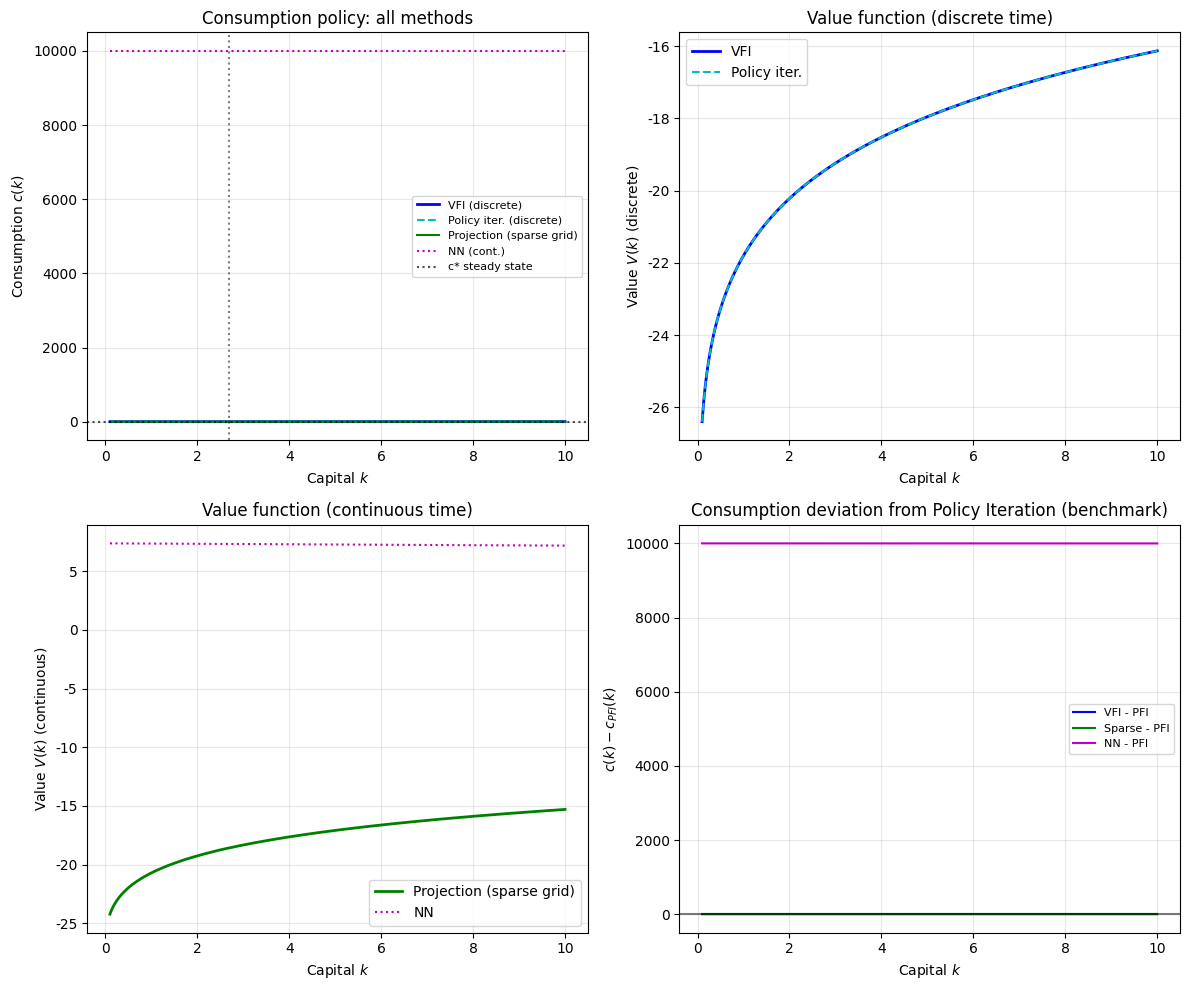

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Panel 1: Consumption policy c(k) – all methods
ax = axes[0, 0]
ax.plot(k_fine, c_vfi_fine, 'b-', lw=2, label='VFI (discrete)')
ax.plot(k_fine, c_pfi_fine, 'c--', lw=1.5, label='Policy iter. (discrete)')
if not np.any(np.isnan(c_sg_fine)):
    ax.plot(k_fine, c_sg_fine, 'g-', lw=1.5, label='Projection (sparse grid)')
if c_nn_fine is not None:
    ax.plot(k_fine, c_nn_fine, 'm:', lw=1.5, label='NN (cont.)')
ax.axhline(c_star, color='k', ls=':', alpha=0.7, label='c* steady state')
ax.axvline(k_star, color='k', ls=':', alpha=0.5)
ax.set_xlabel('Capital $k$')
ax.set_ylabel('Consumption $c(k)$')
ax.set_title('Consumption policy: all methods')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)

# Panel 2: Value function – discrete time
ax = axes[0, 1]
ax.plot(k_fine, V_vfi_fine, 'b-', lw=2, label='VFI')
ax.plot(k_fine, V_pfi_fine, 'c--', lw=1.5, label='Policy iter.')
ax.set_xlabel('Capital $k$')
ax.set_ylabel('Value $V(k)$ (discrete)')
ax.set_title('Value function (discrete time)')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 3: Value function – continuous time
ax = axes[1, 0]
if not np.any(np.isnan(V_sg_fine)):
    ax.plot(k_fine, V_sg_fine, 'g-', lw=2, label='Projection (sparse grid)')
if V_nn_fine is not None:
    ax.plot(k_fine, V_nn_fine, 'm:', lw=1.5, label='NN')
ax.set_xlabel('Capital $k$')
ax.set_ylabel('Value $V(k)$ (continuous)')
ax.set_title('Value function (continuous time)')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 4: Difference in c(k) from benchmark (Policy iteration)
ax = axes[1, 1]
ax.plot(k_fine, c_vfi_fine - c_pfi_fine, 'b-', lw=1.5, label='VFI - PFI')
if not np.any(np.isnan(c_sg_fine)):
    ax.plot(k_fine, c_sg_fine - c_pfi_fine, 'g-', lw=1.5, label='Sparse - PFI')
if c_nn_fine is not None:
    ax.plot(k_fine, c_nn_fine - c_pfi_fine, 'm-', lw=1.5, label='NN - PFI')
ax.axhline(0, color='k', ls='-', alpha=0.5)
ax.set_xlabel('Capital $k$')
ax.set_ylabel('$c(k) - c_{PFI}(k)$')
ax.set_title('Consumption deviation from Policy Iteration (benchmark)')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Summary table: which approach might have problems?

We use **Policy iteration** as the benchmark (discrete-time, typically very accurate). Large deviations in $c(k)$ or in steady-state consumption at $k^*$ suggest a potential problem with that method.

In [ ]:
c_bench = c_pfi_fine

def stats(name, c_method):
    diff = c_method - c_bench
    max_abs = np.max(np.abs(diff))
    rmse = np.sqrt(np.mean(diff**2))
    # Consumption at steady-state k (interpolate if needed)
    c_at_star = np.interp(k_star, k_fine, c_method)
    return {
        'Method': name,
        'max|Δc|': max_abs,
        'RMSE(c)': rmse,
        'c(k*)': c_at_star,
        '|c(k*)-c*|': np.abs(c_at_star - c_star)
    }

rows = [
    stats('VFI (discrete)', c_vfi_fine),
    stats('Policy iter. (benchmark)', c_pfi_fine),
]
if not np.any(np.isnan(c_sg_fine)):
    rows.append(stats('Projection (sparse grid)', c_sg_fine))
if c_nn_fine is not None:
    rows.append(stats('NN (cont.)', c_nn_fine))

import pandas as pd
df = pd.DataFrame(rows)
df = df.set_index('Method')
print("Benchmark: Policy iteration. Steady state c* = {:.4f} at k* = {:.4f}".format(c_star, k_star))
print(df.to_string())
print("\nInterpretation: Large 'max|Δc|' or '|c(k*)-c*|' for a method suggests that method may have problems (e.g. grid, convergence, or residual accuracy).")

Benchmark: Policy iteration. Steady state c* = 1.0767 at k* = 2.6918
                            max|Δc|    RMSE(c)      c(k*)    |c(k*)-c*|
Method                                                                 
VFI (discrete)             0.000000   0.000000   1.076719  7.982565e-07
Policy iter. (benchmark)   0.000000   0.000000   1.076719  7.982565e-07
Projection (sparse grid)   0.061765   0.032664   1.092170  1.544978e-02
NN (cont.)                12.222191  10.469760  11.696612  1.061989e+01

Interpretation: Large 'max|Δc|' or '|c(k*)-c*|' for a method suggests that method may have problems (e.g. grid, convergence, or residual accuracy).


## 8. Optional: Save NN results for future comparison

If you ran the full `growth-nn.ipynb`, you can save `k_test`, `V_pred`, `c_pred` to `results_nn.npz` in the notebook folder so this comparison notebook can load them without re-training. Example in the ML notebook:

```python
np.savez('results_nn.npz', k=k_test, V=V_pred, c=c_pred)
```